In [1]:
import math
import warnings

from IPython.display import display
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import linear_model
import statsmodels.formula.api as smf

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

# Suppress annoying harmless error.
warnings.filterwarnings(
    action="ignore",
    module="scipy",
    message="^internal gelsd"
)

In [2]:
# Acquire, load, and preview the data.
data = pd.read_csv('Advertising.csv')
display(data.head())

# Instantiate and fit our model.
regr = linear_model.LinearRegression()
Y = data['Sales'].values.reshape(-1, 1)
X = data[['TV','Radio','Newspaper']]
# Square TV radio, and newspaper in order to achieve homoscedasticity.
data['TV Sqrd'] = data['TV'] * data['TV']
data['Radio Sqrd'] = data['Radio'] * data['Radio']
data['Newspaper Sqrd'] = data['Newspaper'] * data['Newspaper']
X2 = data[['TV Sqrd', 'Radio Sqrd', 'Newspaper Sqrd']]
regr.fit(X2, Y)
data['Sales Sqrd'] = data['Sales'] * data['Sales']
Y2 = data['Sales Sqrd'].values.reshape(-1, 1) 

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X2, Y))

,Unnamed: 0,TV,Radio,Newspaper,Sales
0,1,230.100,37.800,69.200,22.100
1,2,44.500,39.300,45.100,10.400
2,3,17.200,45.900,69.300,9.300
3,4,151.500,41.300,58.500,18.500
4,5,180.800,10.800,58.400,12.900



Coefficients: 
 [[ 1.42707531e-04  3.68654872e-03 -8.28260101e-05]]

Intercept: 
 [7.2029644]

R-squared:
0.7999736844245878


I achieve a better R squared value if I only square my x variables and not my y variable. 

# Assumption two: multivariate normality
The error from the model (calculated by subtracting the model-predicted values from the real outcome values) should be normally distributed. Since ordinary least squares regression models are fitted by choosing the parameters that best minimize error, skewness or outliers in the error can result in serious miss-estimations.

Outliers or skewness in error can often be traced back to outliers or skewness in data.

In [3]:
# I will look for outliers in my data and then remove them. 
print(data.describe())
# It seems like the biggest problem is somewhere in tv since it has the highest sd. 
#data[data['TV'] > 290]
# 30, 35, 42, 101

data = data.drop([30, 35, 42, 101])

       Unnamed: 0      TV   Radio  Newspaper   Sales   TV Sqrd  Radio Sqrd  \
count     200.000 200.000 200.000    200.000 200.000   200.000     200.000   
mean      100.500 147.042  23.264     30.554  14.023 28955.592     760.539   
std        57.879  85.854  14.847     21.779   5.217 25565.429     735.808   
min         1.000   0.700   0.000      0.300   1.600     0.490       0.000   
25%        50.750  74.375   9.975     12.750  10.375  5531.958      99.502   
50%       100.500 149.750  22.900     25.750  12.900 22425.065     524.570   
75%       150.250 218.825  36.525     45.100  17.400 47884.698    1334.078   
max       200.000 296.400  49.600    114.000  27.000 87852.960    2460.160   

       Newspaper Sqrd  Sales Sqrd  
count         200.000     200.000  
mean         1405.484     223.716  
std          1863.383     160.573  
min             0.090       2.560  
25%           162.570     107.643  
50%           663.085     166.410  
75%          2034.010     302.760  
max      

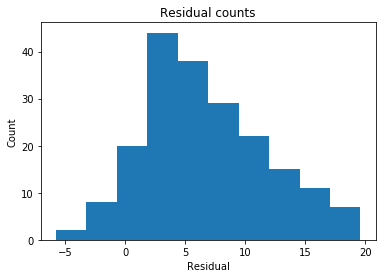

In [4]:
Y3 = data['Sales'].values.reshape(-1, 1)
X3 = data[['TV','Radio','Newspaper']]

# Extract predicted values.
predicted = regr.predict(X3).ravel()
actual = data['Sales']

# Calculate the error, aka residual.
residual = actual - predicted


plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()


- There aren't any extreme outliers anymore but I can't help but feel that my PCA did a better job of giving me a normal distribution. 

# Assumption three: homoscedasticity
The distribution of your error terms (its "scedasticity"), should be consistent for all predicted values, or homoscedastic.

For example, if your error terms aren't consistently distributed and you have more variance in the error for large outcome values than for small ones, then the confidence interval for large predicted values will be too small because it will be based on the average error variance. This leads to overconfidence in the accuracy of your model's predictions.

Some fixes to heteroscedasticity include transforming the dependent variable and adding features that target the poorly-estimated areas. For example, if a model tracks data over time and model error variance jumps in the September to November period, a binary feature indicating season may be enough to resolve the problem.

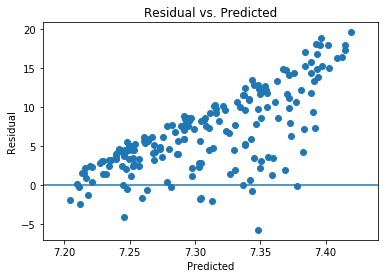

In [5]:
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

# Hm... looks a bit concerning.

Squaring the variables gave my graph a better homoscedasticity.

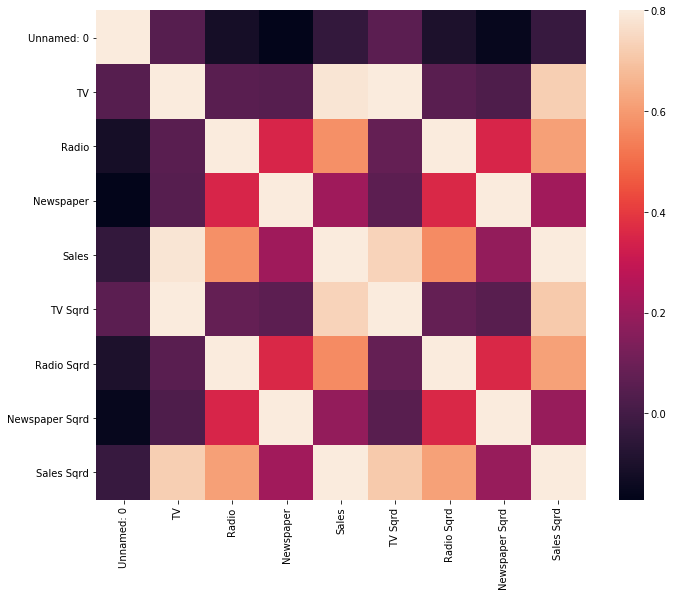

In [6]:
# Your code here.
corrmat = data.corr()
 
# Set up the matplotlib figure.
f, ax = plt.subplots(figsize=(12, 9))

# Draw the heatmap using seaborn
sns.heatmap(corrmat, vmax=.8, square=True)
plt.show()

Seems like radio and sales correlation is pretty high, around 0.6.

In [7]:
from sklearn.preprocessing import StandardScaler
features = ['TV', 'Radio', 'Newspaper']
# Separating out the features
x = data.loc[:, features].values
# Separating out the target
y = data.loc[:,['Sales']].values
# Standardizing the features
x = StandardScaler().fit_transform(x)

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

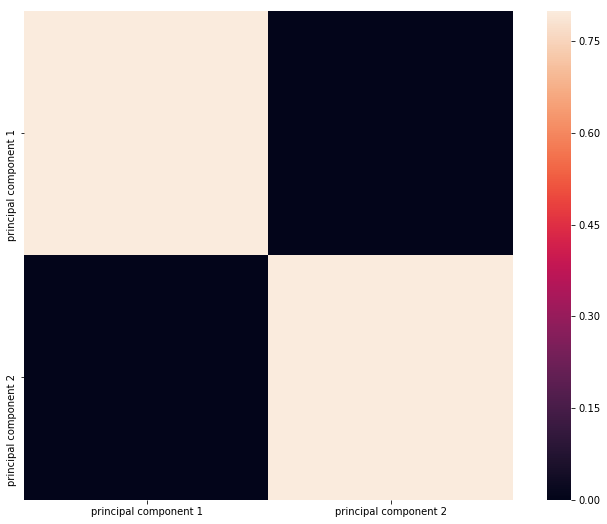

In [8]:
corrmat = principalDf.corr()
 
# Set up the matplotlib figure.
f, ax = plt.subplots(figsize=(12, 9))

# Draw the heatmap using seaborn
sns.heatmap(corrmat, vmax=.8, square=True)
plt.show()

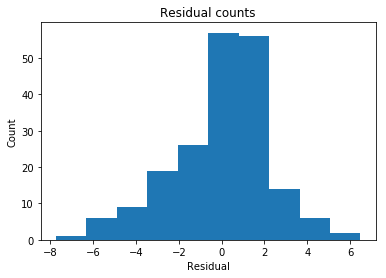

In [9]:
# Instantiate and fit our model.
regr = linear_model.LinearRegression()
Y = data['Sales'].values.reshape(-1, 1)
X = principalDf[['principal component 1','principal component 2']]
regr.fit(X, Y)

# Extract predicted values.
predicted2 = regr.predict(X).ravel()
actual2 = data['Sales']

# Calculate the error, aka residual.
residual2 = actual2 - predicted2

plt.hist(residual2)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()


There are outliers, but at least my data isn't skewed anymore and looks normally distributed and the outliers aren't too extreme either. 

- Seems like I don't even need the second principal component.
- I thought that using a PCA might have helped me reach multivariate normality since PCA transformed the data.
- The distribution of the data is normalized without any extreme outliers now. 
- Using PCA also helped me reach a low multi collinearity score. 